## SKYFAST: Tutorial
##### This tutorial shows how to use SKYFAST, a Python code based on FIGARO (Rinaldi&Del Pozzo, 2022) for the rapid localization of gravitational wave hosts



### Installation

Create a conda environment:

`conda create --name skyfast_env python==3.9`.

Then activate it:
`conda activate skyfast_env`

Then download the package from git:

`git clone https://github.com/gabrieledemasi/skyfast.git`


Move in the downloaded directory and install the package:

` python setup.py install`




load the Glade galaxy catalog
* Download the 6Gb file from http://glade.elte.hu/;
* 
* Preprocess it running `make_glade -i "/path_to_the_file"`: this create, in the same folder, a lighter hdf5 file, that can be passed to skyfast




In [18]:
glade_file = '/home/dottorato/glade/glade+.hdf5'

In [2]:
#import figaro
import numpy as np
from tqdm import tqdm
from skyfast.skyfast import skyfast
from skyfast.coordinates import celestial_to_cartesian



Now we load the parameter estimation samples of our preferred event: that is of course GW150914

In [9]:
from figaro.load import load_single_event
samples, name = load_single_event('data/GW150914_volume.txt') 
samples, name = load_single_event('data/GW170817_noEM.txt') 

import os
import h5py
'''
result_dir = '/Users/gabrieledemasi/dottorato/Rapid Localization/50_BNS'
data = f'BNS_data0_0_analysis_H1L1V1_merge_result.hdf5'
file = h5py.File(os.path.join(result_dir, data))
print(file.keys())
posterior = file['posterior']

ra = np.array(posterior['ra'])

dec = np.array(posterior['dec'])
d_L = np.array(posterior['luminosity_distance'])
theta_jn = np.array(posterior['theta_jn'])


truth = np.array([np.array(file['injection_parameters']['ra']), np.array(file['injection_parameters']['dec']), np.array(file['injection_parameters']['luminosity_distance']), np.array(file['injection_parameters']['theta_jn'])])
print(truth)


samples = list(np.array([ra, dec, d_L]).T)
'''

"\nresult_dir = '/Users/gabrieledemasi/dottorato/Rapid Localization/50_BNS'\ndata = f'BNS_data0_0_analysis_H1L1V1_merge_result.hdf5'\nfile = h5py.File(os.path.join(result_dir, data))\nprint(file.keys())\nposterior = file['posterior']\n\nra = np.array(posterior['ra'])\n\ndec = np.array(posterior['dec'])\nd_L = np.array(posterior['luminosity_distance'])\ntheta_jn = np.array(posterior['theta_jn'])\n\n\ntruth = np.array([np.array(file['injection_parameters']['ra']), np.array(file['injection_parameters']['dec']), np.array(file['injection_parameters']['luminosity_distance']), np.array(file['injection_parameters']['theta_jn'])])\nprint(truth)\n\n\nsamples = list(np.array([ra, dec, d_L]).T)\n"

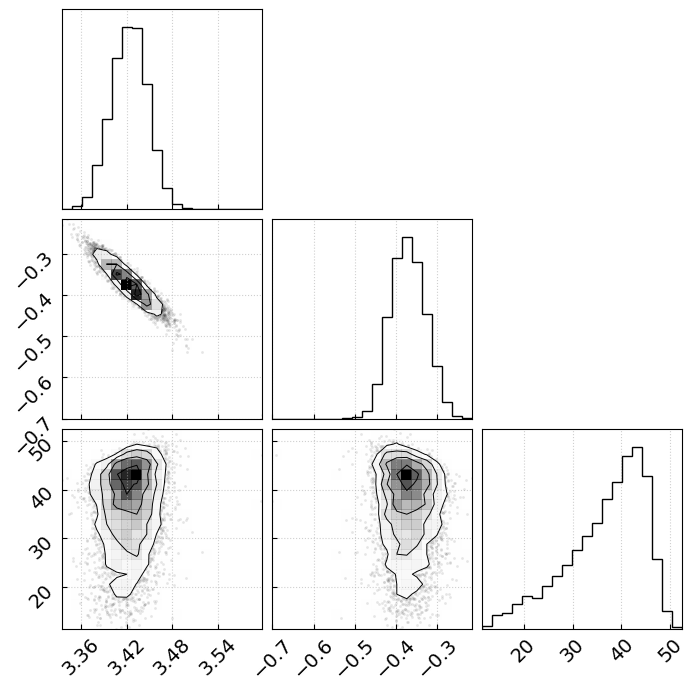

In [10]:
from corner import corner 
c = corner(np.array(samples))

In [11]:
from figaro.utils import get_priors
eps = 0.1
sam = np.array(samples).T
print(sam[2])
print(np.max(sam[2]))
max = np.max(sam[2])
print(max)
bounds = np.array([[0.-eps, 2*np.pi+eps], [-np.pi/2 -eps, np.pi/2+eps], [0.-eps, 100+eps]])
a = get_priors(bounds = bounds,samples=np.array(samples), probit=True)
print(a)


[26.27557198 44.27078372 24.2870412  ... 28.14647679 40.92532711
 36.71059079]
52.327917812777976
52.327917812777976
(0.04, array([[ 1.67499080e-05, -2.88226520e-05,  9.24623229e-04],
       [-2.88226520e-05,  5.69631525e-05, -5.19875795e-04],
       [ 9.24623229e-04, -5.19875795e-04,  2.38771646e+00]]), 5, array([  0.24051446,  -0.32116905, -11.9833211 ]))


And finally we initialize a skyfast class:

In [12]:

# working; std = np.array([1, 0.05, 1]),
dens = skyfast(500, #maximum distance at which we expect to have a distance sample
                n_gridpoints = [500, 250, 50],
                prior_pars=a,
                entropy = True,  #If True, an intermediate skymap is created when the convergence is reached
                n_entropy_MC_draws=1e3)




To reconstruct the 3D probability volume, we use the `intermediate_skymap` method, which takes the MCMC samples one by one. The sample returned by a MCMC are in general in celestial coordinate, but at the moment skyfast accept only cartesian coordinates, so we must convert the samples before using:

Since the samples that we use are likelihood_ordered, we shuffle them:

Now we are read to pass the samples to skyfast: remind that the must passed one by one!

As the samples are passed to intermediate_skymap, they are added to the DPGMM mixture.

If `entropy=True` then the information entropy is computed, and if the convergence is reached then an intermediate skymap is released.



In [13]:
dens.initialise()
np.random.shuffle(samples)
for i in tqdm(range(len(samples))):
        dens.intermediate_skymap(samples[i])

        

 58%|█████▊    | 2936/5042 [02:45<01:58, 17.77it/s]


KeyboardInterrupt: 

302


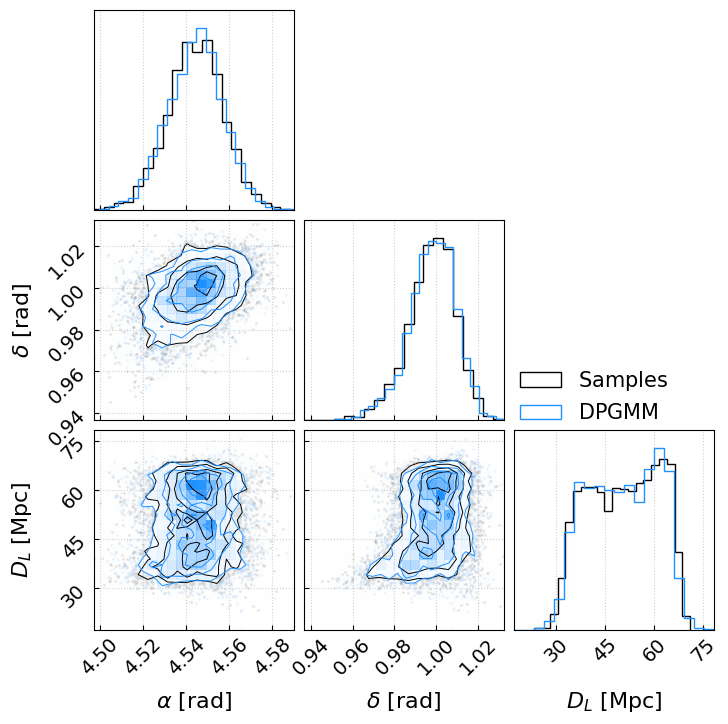

In [8]:
dens.plot_samples(samples)
dens.make_entropy_plot()

#dens.make_skymap(final_map = True)
#dens.make_volume_map(final_map = True)
print(dens.N_clu[-1])